In [2]:
# -*- coding: utf-8 -*-
"""
Created on 2023/04/11
Revised on 2024/03/10

@author: mjofre - Marc Jofre
e-mail: marc.jofre@upc.edu
Technical University of Catalonia - Universitat Politècnica de Catalunya (UPC)
Network Engineering Department
"""
###########################################################################
# Seminar on Quantum Technologies for Cybersecurity: Networking and Systems

import os, sys, time
import numpy as np
import math
import matplotlib.pyplot as plt
from google.colab import files
import matplotlib.style
import matplotlib as mpl
#print(plt.style.available)
mpl.style.use('default')

try:
  import qiskit
  import qiskit_aer
except:
  print("installing qiskit...")
  !pip install qiskit -U --quiet
  !pip install qiskit_aer -U --quiet
  print("installed qiskit.")
  import qiskit
  import qiskit_aer

try:
  import qutip
  # https://qutip.org/docs/latest/
except ImportError:
  print("installing qutip...")
  !pip install qutip --quiet
  print("installed qutip.")
  import qutip

installing qiskit...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 31.9 MB/s eta 0:00:00
installed qiskit.


{'110': 127, '001': 132, '000': 137, '010': 123, '100': 96, '101': 135, '111': 128, '011': 122}


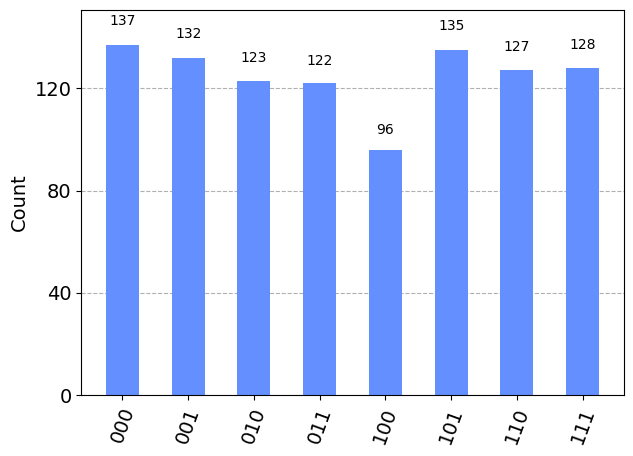

In [4]:
######################################################################################
# Quantum Fourier transform (QFT)
# Fundamental building block of many quantum algorithms
# https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit

# create a 3-qubit quantum circuit
qc=QuantumCircuit(3)

# apply the QFT to the first 3 qubits
qc.h(0)
qc.cp(1/2,0,1)
qc.cp(1,0,2)
qc.h(1)
qc.cp(1,1,2)
qc.h(2)

# mesure all qubits
qc.measure_all()

# simulate the circuit on a classical computer
# Construct an ideal simulator
aersim = AerSimulator()
result=aersim.run(qc,shots=1000).result()

# print the measurement results
counts=result.get_counts(qc)
print(counts)
plot_histogram(counts)

{'00': 1024}


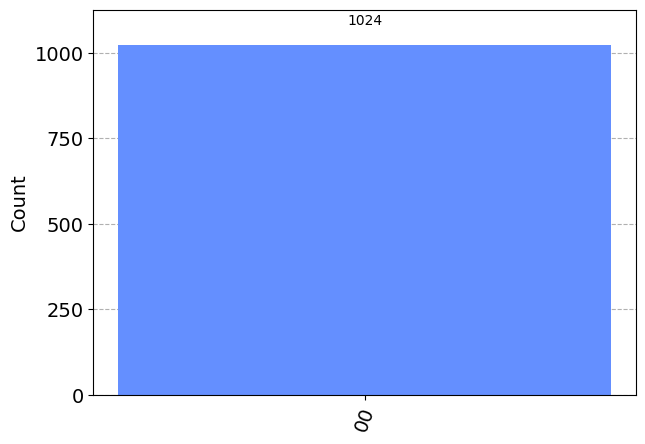

In [8]:
######################################################################################
# Quantum phase estimation (QPE)
# Estimates the phase of an eigenvector of a unitary operator
# https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile

# Define the unitary operation for which we want to estimate the phase
theta=0.5
unitary=QuantumCircuit(2)
unitary.p(theta,1) # previously u1
unitary.cx(0,1)

# create the Quantum Phase Estimation circuit
qpe=QuantumCircuit(3,2)
qpe.h(2)
for i in range(2):
  qpe.append(unitary,[i,2])
  qpe.crz(2**(i+1)*theta,i,2) # previously cu1
qpe.measure([0,1],[0,1])

# Construct an ideal simulator
aersim = AerSimulator()
qpe_t = transpile(qpe, aersim)
result=aersim.run(qpe_t,shots=1024).result()
counts=result.get_counts(qpe)

# Print the results
print(counts)
plot_histogram(counts)

In [20]:
###################################################################################
# Grover's algorithm
# Quantum algorithm designed to search and unsorted database with N entries in O(sqrt(N)) time, compared to O(N) time required by classical algorithms
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import MCMT
import math

# Function to create a quantum circuit for the search problem
def create_circuit(n,search_value):
  # Step 1: create a quantum register of size 'n'
  quantum_register=QuantumRegister(n,'q')
  classical_register=ClassicalRegister(n,'c')
  quantum_circuit=QuantumCircuit(quantum_register,classical_register)

  # Step 2: Apply Hadamard gates to all qubits
  for i in range(n):
    quantum_circuit.h(i)

  # Step 3: Oracle to mark the search value
  search_index=int(math.log2(search_value))
  oracle=QuantumCircuit(n)
  oracle.x(search_index)
  oracle.h(n-1)
  oracle.append(MCMT('x', 2, 1), list(range(n)))# oracle.mct(list(range(n-1)),n-1) # Multi-controlled Toffoli gate#oracle.mct(list(range(n-1)),n-1) # Multi-controlled Toffoli gate
  oracle.h(n-1)
  oracle.x(search_index)

  # Step 4: Amplification to increase the probability of measuring the search value
  amplification=QuantumCircuit(n)
  for i in range(n):
    amplification.h(i)
  for i in range(n):
    amplification.x(i)
  amplification.h(n-1)
  amplification.append(MCMT('x', 2, 1), list(range(n)))#amplification.mct(list(range(n-1)),n-1)
  amplification.h(n-1)
  for i in range(n):
    amplification.x(i)
  for i in range(n):
    amplification.h(i)

  # Step 5: Combine all circuits
  #grover_circuit=quantum_register+oracle+amplification
  grover_circuit=quantum_circuit.compose(oracle.compose(amplification))

  grover_circuit.measure(quantum_register,classical_register)

  return grover_circuit

# Grover's algorithm function
def grover_algorithm(n,search_value):
  # Step 1: Create the quantum circuit for the search problem
  grover_circuit=create_circuit(n,search_value)

  # Step 2: Execute the circuit on a simulator
  # Construct an ideal simulator
  aersim = AerSimulator()
  grover_circuit_t =transpile(grover_circuit,aersim)
  result=aersim.run(grover_circuit_t).result()
  measured_registers=result.get_counts()
  print(measured_registers)
  # Step 3: Extract the search result form the measured registers
  for measured_register in measured_registers:
    search_result=int(measured_register,2)
    return search_result

# Example usage
n=3
search_value=1
search_result=grover_algorithm(n,search_value)
print(f"The search result for {search_value} in {2**n} entries is {search_result}.")

{'100': 31, '101': 36, '001': 44, '010': 30, '000': 35, '011': 26, '111': 37, '110': 785}
The search result for 1 in 8 entries is 4.


# Shor's algorithm and factoring product of prime factors
https://qiskit.org/textbook/ch-algorithms/shor.html
5. Factoring from Period Finding
Not all factoring problems are difficult; we can spot an even number instantly and know that one of its factors is 2. In fact, there are specific criteria for choosing numbers that are difficult to factor, but the basic idea is to choose the product of two large prime numbers.

A general factoring algorithm will first check to see if there is a shortcut to factoring the integer (is the number even? Is the number of the form  
N
=
a
b
 ?), before using Shor’s period finding for the worst-case scenario. Since we aim to focus on the quantum part of the algorithm, we will jump straight to the case in which N is the product of two primes.

Example: Factoring 15
To see an example of factoring on a small number of qubits, we will factor 15, which we all know is the product of the not-so-large prime numbers 3 and 5.

In [21]:
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.visualization import plot_histogram
from numpy.random import randint
from fractions import Fraction
N = 15
#The first step is to choose a random number, , between  and :

np.random.seed(1) # This is to make sure we get reproduceable results
a = randint(2, 15)
print(a)

#Next we quickly check it isn't already a non-trivial factor of :

from math import gcd # greatest common divisor
gcd(a, N)

#Great. Next, we do Shor's order finding algorithm for a = 7 and N = 15. Remember that the phase we measure will be   where: and  is a random integer between 0 and .

def c_amod15(a, power):
  """Controlled multiplication by a mod 15"""
  if a not in [2,4,7,8,11,13]:
      raise ValueError("'a' must be 2,4,7,8,11 or 13")
  U = QuantumCircuit(4)
  for iteration in range(power):
      if a in [2,13]:
          U.swap(2,3)
          U.swap(1,2)
          U.swap(0,1)
      if a in [7,8]:
          U.swap(0,1)
          U.swap(1,2)
          U.swap(2,3)
      if a in [4, 11]:
          U.swap(1,3)
          U.swap(0,2)
      if a in [7,11,13]:
          for q in range(4):
              U.x(q)
  U = U.to_gate()
  U.name = "%i^%i mod 15" % (a, power)
  c_U = U.control()
  return c_U
def qft_dagger(n):
  """n-qubit QFTdagger the first n qubits in circ"""
  qc = QuantumCircuit(n)
  # Don't forget the Swaps!
  for qubit in range(n//2):
      qc.swap(qubit, n-qubit-1)
  for j in range(n):
      for m in range(j):
          qc.cp(-np.pi/float(2**(j-m)), m, j)
      qc.h(j)
  qc.name = "QFT†"
  return qc
def qpe_amod15(a):
    n_count = 8
    qc = QuantumCircuit(4+n_count, n_count)
    for q in range(n_count):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(3+n_count) # And auxiliary register in state |1>
    for q in range(n_count): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q), [q] + [i+n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT
    qc.measure(range(n_count), range(n_count))
    # Simulate Results
    # Construct an ideal simulator
    aersim = AerSimulator()
    # Setting memory=True below allows us to see a list of each sequential reading
    t_qc = transpile(qc, aersim, optimization_level=3)
    result = aersim.run(t_qc, memory=True).result()
    readings = result.get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase

# From this phase, we can easily find a guess for :
phase = qpe_amod15(a) # Phase = s/r
Fraction(phase).limit_denominator(15) # Denominator should (hopefully!) tell us r

frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)

#Now we have  , we might be able to use this to find a factor of . Since: then: which means  must divide . And if  is also even, then we can write:
#(if   is not even, we cannot go further and must try again with a different value for ). There is then a high probability that the greatest common divisor of  and either , or  is a proper factor of  [2]:

guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

#The cell below repeats the algorithm until at least one factor of 15 is found. You should try re-running the cell a few times to see how it behaves.

a = 7
factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    print("Result: r = %i" % r)
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True


7
Register Reading: 11000000
Corresponding Phase: 0.750000
4
[3, 5]

Attempt 1:
Register Reading: 10000000
Corresponding Phase: 0.500000
Result: r = 2
Guessed Factors: 3 and 1
*** Non-trivial factor found: 3 ***
